In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer 
from utils.utils import DataFrameSelector, AddTreatment, ImputerByRegression, AddAttributes,\
                                AddNullAge, correlation_heatmap, CabinFeature, mislabeled_class
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pickle

In [2]:
titanic_data = pd.read_csv("titanic_data.csv")
test_data = pd.read_csv("test.csv")
split = StratifiedShuffleSplit(n_splits=1, random_state=90, test_size=0.25)
for train_indices, test_indices in split.split(titanic_data, titanic_data["Survived"]):
    train_data = titanic_data.loc[train_indices]
    dev_data = titanic_data.loc[test_indices]
train_labels = train_data["Survived"]
dev_labels = dev_data["Survived"]
train_data.drop(columns=["Survived"], inplace=True)
dev_data.drop(columns=["Survived"], inplace=True)
print(titanic_data[titanic_data["Survived"] == 1][["Fare"]].to_string())


         Fare
1     71.2833
2      7.9250
3     53.1000
8     11.1333
9     30.0708
10    16.7000
11    26.5500
15    16.0000
17    13.0000
19     7.2250
21    13.0000
22     8.0292
23    35.5000
25    31.3875
28     7.8792
31   146.5208
32     7.7500
36     7.2292
39    11.2417
43    41.5792
44     7.8792
47     7.7500
52    76.7292
53    26.0000
55    35.5000
56    10.5000
58    27.7500
61    80.0000
65    15.2458
66    10.5000
68     7.9250
74    56.4958
78    29.0000
79    12.4750
81     9.5000
82     7.7875
84    10.5000
85    15.8500
88   263.0000
97    63.3583
98    23.0000
106    7.6500
107    7.7750
109   24.1500
123   13.0000
125   11.2417
127    7.1417
128   22.3583
133   26.0000
136   26.2833
141    7.7500
142   15.8500
146    7.7958
151   66.6000
156    7.7333
161   15.7500
165   20.5250
166   55.0000
172   11.1333
183   39.0000
184   22.0250
186   15.5000
187   26.5500
190   13.0000
192    7.8542
193   26.0000
194   27.7208
195  146.5208
198    7.7500
204    8.0500
207   

In [3]:
treatment_cols = ["Mrs.", "Mr.", "Master", "Others", "Symbol_name"]
cat_to_1hot_cols = ["Sex", "Embarked"]
new_features_cols = ["SibSp", "Parch"]
adjust_cols = ["Age", "Fare"]
unchanged_cols = ["Pclass"]

add_treatment = Pipeline([
    ("selector", DataFrameSelector(["Name"])),
    ("add_attrib", AddTreatment())
])

cat_to_1hot = Pipeline([
    ("selector", DataFrameSelector(cat_to_1hot_cols)),
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("one-hot", OneHotEncoder(categories="auto", sparse=False))
])

add_features = Pipeline([
    ("selector", DataFrameSelector(new_features_cols)),
    ("add_new_attrib", AddAttributes())
])

adjust_features = Pipeline([
    ("selector", DataFrameSelector(adjust_cols)),
    ("imputer", SimpleImputer(strategy="mean")),
    ("std_scaler", StandardScaler())
])

cabin_feature = Pipeline([
    ("selector", DataFrameSelector(["Cabin"])),
    ("cabin_feature", CabinFeature())
])
    
full_pipeline = FeatureUnion(transformer_list=[
    ("add_treatment", add_treatment),
    ("cat_to_1hot", cat_to_1hot),
    ("add_features", add_features),
    ("adjust_features", adjust_features),
    ("add_unchanged_features", DataFrameSelector(unchanged_cols)),
    ("cabin_feature", cabin_feature)
])
cols = treatment_cols + ["sex1", "sex2", "embarked1", "embarked2", "embarked3"] + \
                                                                                    ["Pos_civil"] + \
                                                                                            ["Age", "Fare", "Pclass", "Cabin"]

In [4]:
train_data_transformed = full_pipeline.fit_transform(train_data, [])
dev_data_transformed = full_pipeline.transform(dev_data)
# train_data_transformed = np.delete(train_data_transformed, 5, 1)
# dev_data_transformed = np.delete(dev_data_transformed, 5, 1)
train_data_transformed.shape

(668, 15)

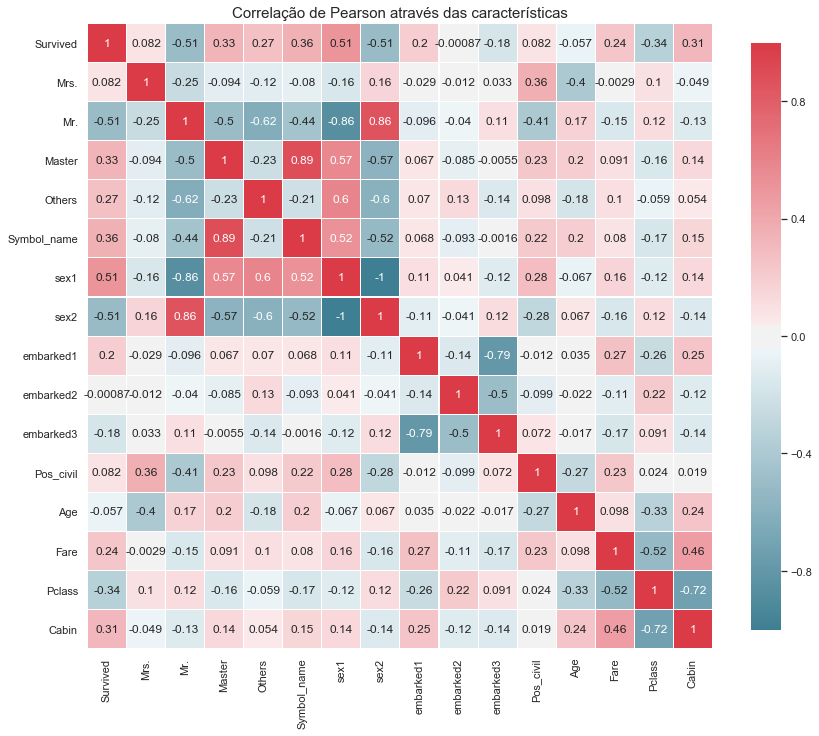

In [5]:
corr_data = np.c_[train_labels, train_data_transformed]
corr_cols = ["Survived"] + cols
df = pd.DataFrame(corr_data, columns = corr_cols)
correlation_heatmap(df)

In [6]:
clf_rfc = RandomForestClassifier(n_estimators = 100, random_state=42)
clf_rfc.fit(train_data_transformed, train_labels)
importances = clf_rfc.feature_importances_
importances = dict(zip(cols, importances))
sorted(importances.items(), key=lambda kv: kv[1], reverse=True)

[('Fare', 0.24041049982854887),
 ('Age', 0.21979619929050923),
 ('Mr.', 0.08630879877909342),
 ('sex1', 0.08038024485958165),
 ('Pos_civil', 0.07662860500465961),
 ('Pclass', 0.0726521606898485),
 ('sex2', 0.06688981439346577),
 ('Symbol_name', 0.03556604476216232),
 ('Cabin', 0.03462635370785822),
 ('Others', 0.017453775082132476),
 ('embarked3', 0.01736341101892576),
 ('Master', 0.01490449999660763),
 ('embarked1', 0.014281870915645796),
 ('Mrs.', 0.012086002240124506),
 ('embarked2', 0.010651719430836325)]

In [7]:
clf_rfc = RandomForestClassifier(n_estimators=30, min_samples_split=8, max_features=12, max_depth=4, 
                                 criterion="entropy", bootstrap=True, random_state=42)

clf_rfc.fit(train_data_transformed, train_labels)

score_train = clf_rfc.score(train_data_transformed, train_labels)
score_dev = clf_rfc.score(dev_data_transformed, dev_labels)

print("Score Train-set: {}\nScore Dev-set: {}".format(score_train, score_dev))

Score Train-set: 0.8592814371257484
Score Dev-set: 0.8565022421524664


In [8]:
clf_gbc = GradientBoostingClassifier(n_estimators=100, min_samples_split=5, max_features=4, max_depth=4, 
                                 learning_rate=0.02, random_state=42)

clf_gbc.fit(train_data_transformed, train_labels)

score_train = clf_gbc.score(train_data_transformed, train_labels)
score_dev = clf_gbc.score(dev_data_transformed, dev_labels)

print("Score Train-set: {}\nScore Dev-set: {}".format(score_train, score_dev))

Score Train-set: 0.8667664670658682
Score Dev-set: 0.8475336322869955


In [9]:
importances = clf_gbc.feature_importances_
importances = dict(zip(cols, importances))
sorted(importances.items(), key=lambda kv: kv[1], reverse=True)

[('sex1', 0.1726433133853377),
 ('sex2', 0.14914220277995838),
 ('Pclass', 0.1334767176107158),
 ('Mr.', 0.12205415331464321),
 ('Fare', 0.10373675710954934),
 ('Pos_civil', 0.06545931930492609),
 ('Age', 0.06197867909211666),
 ('Symbol_name', 0.06116697572645705),
 ('Cabin', 0.044571554459436405),
 ('Mrs.', 0.022738225406367423),
 ('Others', 0.01728825290587),
 ('embarked1', 0.013180458885332022),
 ('embarked3', 0.011588477006567139),
 ('Master', 0.011473146571144588),
 ('embarked2', 0.009501766441578182)]

In [10]:
# params = {"max_depth": [5, 4, 3, None],
#               "learning_rate": [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0],
#               "max_features": [4, 5, 7, 9, 11, 14],
#               "min_samples_split": [2, 3, 4, 5, 8, 11],
# #               "bootstrap": [True, False],
# #               "criterion": ["gini", "entropy"],
#               "n_estimators": [10, 30, 60, 100]}

# clf_rfc = GradientBoostingClassifier()
# grid = RandomizedSearchCV(clf_rfc, params, n_iter=600, cv=3)
# grid.fit(train_data_transformed, train_labels)

# print("Best Params: ", grid.best_params_)

In [11]:
clf_svc = SVC(C=80, gamma=0.02)
clf_svc.fit(train_data_transformed, train_labels)
score_train = clf_svc.score(train_data_transformed, train_labels)
score_dev = clf_svc.score(dev_data_transformed, dev_labels)

print("Score Train-set: {}\nScore Dev-set: {}".format(score_train, score_dev))

Score Train-set: 0.8607784431137725
Score Dev-set: 0.8295964125560538


In [12]:
# params = {'kernel' : ['rbf'], 
#           'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2],
#           'C': [10, 30, 50, 60, 80, 100, 500]}

# grid = GridSearchCV(clf_svc, params, cv=3)
# grid.fit(train_data_transformed, train_labels)
# print("Best Params: ", grid.best_params_)

In [13]:
# params = {'n_estimators' : [5, 10, 20, 40, 50, 80, 100, 200], 
#           'learning_rate': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.5, 1.0]}

# clf_adb = AdaBoostClassifier()
# grid = GridSearchCV(clf_adb, params, cv=3)
# grid.fit(train_data_transformed, train_labels)
# print("Best Params: ", grid.best_params_)

clf_adb = AdaBoostClassifier(learning_rate=1.0, n_estimators=10)
clf_adb.fit(train_data_transformed, train_labels)

score_train = clf_adb.score(train_data_transformed, train_labels)
score_dev = clf_adb.score(dev_data_transformed, dev_labels)

print("Score Train-set: {}\nScore Dev-set: {}".format(score_train, score_dev))

Score Train-set: 0.8233532934131736
Score Dev-set: 0.8340807174887892


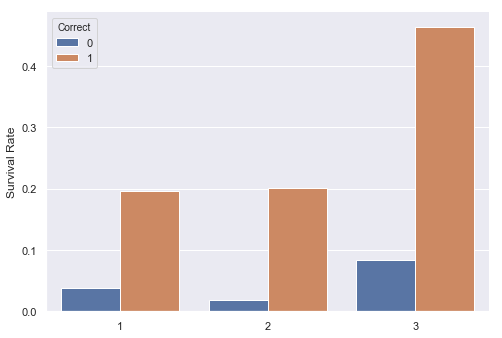

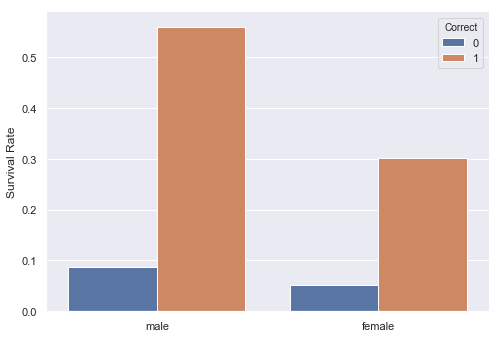

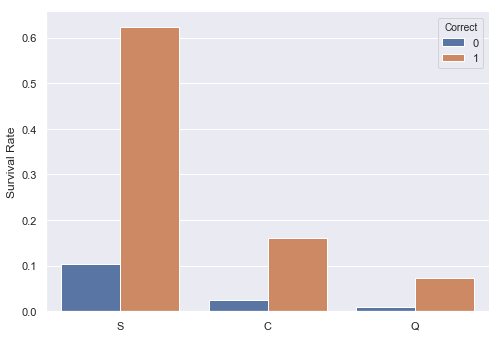

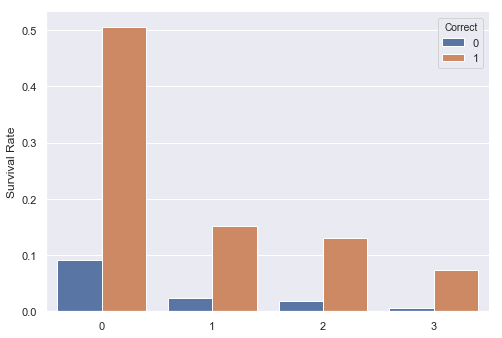

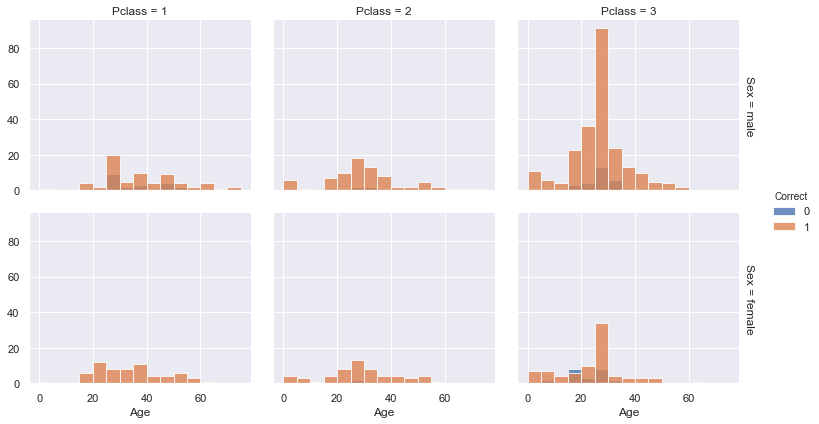

In [14]:
mislabeled_class(clf_svc, train_data, train_data_transformed, train_labels)

In [15]:
passengerId = test_data["PassengerId"]
test_data_transformed = full_pipeline.transform(test_data)

survived = clf_gbc.predict(test_data_transformed)

submission = pd.concat([pd.DataFrame(passengerId), pd.DataFrame({'Survived':survived})], axis=1)
submission.to_csv('submission.csv', index=False)

In [16]:
x = pd.read_csv("submission.csv")
y = pd.read_csv("submission_1.csv")

(abs(x["Survived"]-y["Survived"])).sum()

18

In [17]:
# filename = "GradientBoostingClassifier.sav"
# pickle.dump(clf_gbc, open(filename, 'wb'))